<a href="https://colab.research.google.com/github/GermanOmar/LAFW/blob/master/LAFW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning regressors for UTS prediction in laser-assisted rotary friction welding


<a href="https://ibb.co/h2Prbq5"><img src="https://i.ibb.co/2cDRxb2/Imagen1.png" WIDTH="329" HEIGHT="713"  border="0"></a>

 Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle

 Upload database:

In [3]:
!git clone https://github.com/GermanOmar/LAFW

Cloning into 'LAFW'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [4]:
#Experimental data
data = pd.read_table('data.txt') 
data.describe()


,N,FP,LP,UTS
count,48.000000,48.000000,48.000000,48.000000
mean,1700.000000,17.500000,600.000000,148.130417
std,101.058231,3.537038,378.125275,40.693220
min,1600.000000,14.000000,0.000000,60.300000
25%,1600.000000,14.000000,450.000000,114.300000
50%,1700.000000,17.500000,700.000000,149.750000
75%,1800.000000,21.000000,850.000000,176.825000
max,1800.000000,21.000000,1000.000000,215.400000



Setting inputs - output:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


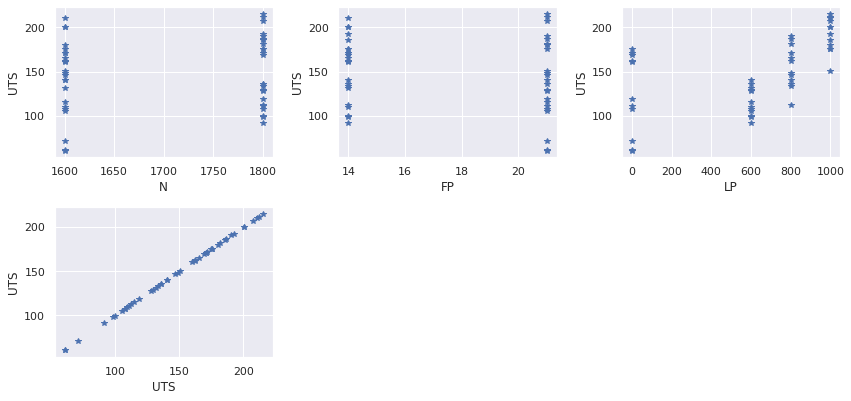

In [5]:
fields = [ 'N', 'FP','LP', 'UTS']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((12,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['UTS'], 'b*')
  plt.xlabel(field)
  plt.ylabel('UTS')

plt.tight_layout()

X=data[[ 'N', 'FP','LP']]
Y=data['UTS'][:,None]



#fig.tight_layout()

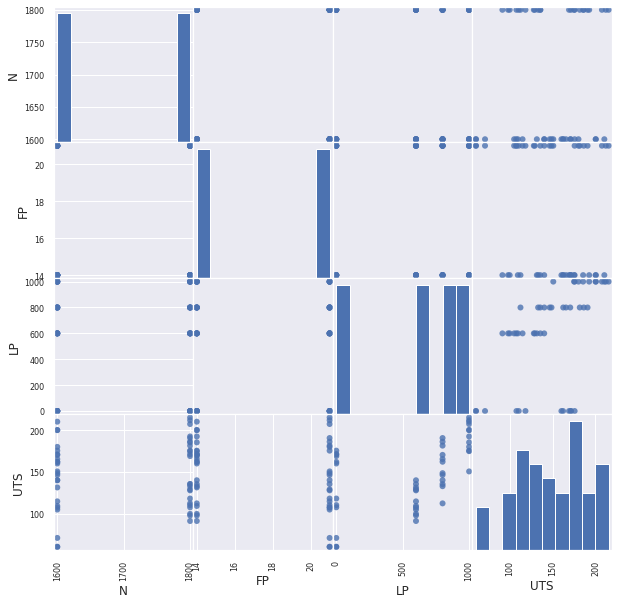

In [7]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (10,10))
import warnings
warnings.filterwarnings("ignore")

#UTS prediction

In [8]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 38  test samples: 10


#Results:

###GBR 

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=5000, random_state=32, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 62.8568703869844

R2:  0.9760458527967671
RMSE:  7.9282324882021715
MAE:  7.355511466699556
IM:  10.814850582643354



### GPs

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.01, normalize_y=True)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

Gaussian Process
MSE train: 43.538229424467985
MSE test: 62.859055498963095
MSE train < MSE test? True

R2_train:  0.9676807872307465
R2_test:  0.976045020071662

R2:  0.976045020071662
RMSE:  7.92837029275015
MAE:  7.3556709922309125
IM:  10.815060105518311



### RFR

In [12]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=1000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-----------------------------
MSE test: 219.7153708011935

R2:  0.9162685908066701
RMSE:  14.822799020468215
MAE:  10.828610306349649
IM:  18.35704722761427



### XGB

In [13]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0, n_estimators=1000, max_depth=8)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [14]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [15]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.9760406298274966


In [16]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 62.87057571740937

R2:  0.9760406298274966
RMSE:  7.92909677815887
MAE:  7.356282196044921
IM:  10.81600839111527



### MLP

In [17]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=4,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=42, max_iter=2000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.6341583961662984
RMSE:  7.92909677815887
MAE:  24.801313460429615
IM:  26.040536959882225



### DTR

In [18]:
from sklearn.tree import DecisionTreeRegressor
DT=DecisionTreeRegressor(max_depth=20)

#START TRAINING
DT.fit(X_train,y_train)
#PREDICTION
y_pred=DT.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.9760461263765746
RMSE:  7.92909677815887
MAE:  7.355500000000001
IM:  10.815476399838841



# Comparisson

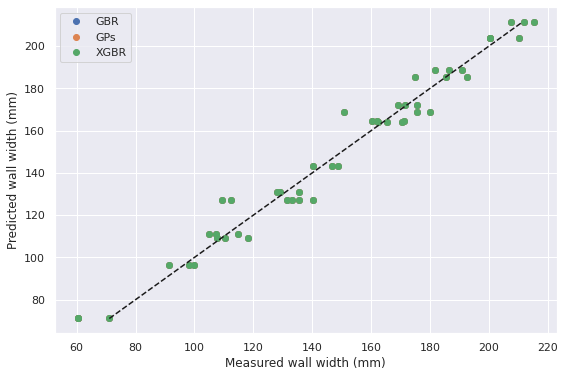

In [19]:
models = [ GBR ,  GP, xgbr]
labels = ['GBR', 'GPs', 'XGBR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted wall width (mm)')
plt.xlabel('Measured wall width (mm)')
plt.legend()  
  

Worst

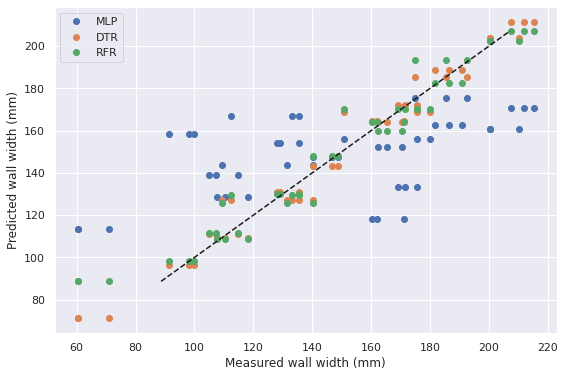

In [20]:
models = [ MLP, DT, RFR  ]
labels = [ 'MLP', 'DTR', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted wall width (mm)')
plt.xlabel('Measured wall width (mm)')
plt.legend()  

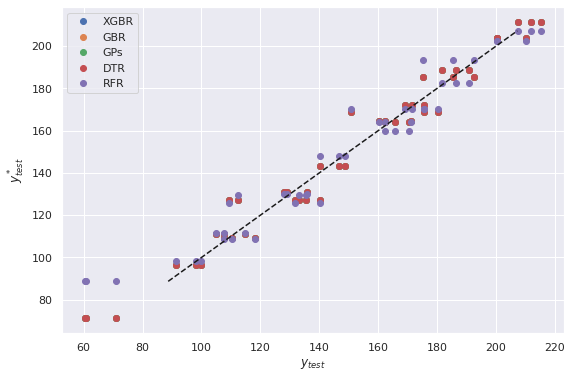

In [21]:
models = [xgbr,  GBR,  GP, DT,  RFR ]
labels = ['XGBR',  'GBR',   'GPs', 'DTR',  'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()

# CROSS-VALIDATION

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [xgbr,  GBR,  GP, DT, MLP, RFR ]
labels = ['XGBR',  'GBR',   'GPs', 'DTR', 'MLP', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.8719 | 159.4250 | 9.4905 | 15.7959 
            GBR | 0.9073 | 113.6947 | 8.3484 | 13.5425 
            GPs | 0.7398 | 324.2730 | 10.9564 | 21.0804 
            DTR | 0.7731 | 284.9736 | 11.7279 | 20.5565 
            MLP | -0.2878 | 1554.7296 | 33.6693 | 51.8653 
            RFR | 0.7555 | 302.5363 | 12.4267 | 21.3780 
--------------------------------------------------------------
